In [1]:
from processing import monophony
from processing.monophony import *
from models import transformer_encoder_decoder
from models import *

Using TensorFlow backend


In [2]:
monophony._group_subdirs_contents(from_dir='lpd_5/lpd_5_full', to_dir='lpd_5/all')

Total Tracks:  174154


'lpd_5/all'

In [2]:
model = transformer_encoder_decoder(ignore_last_class=False)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, 1)]            0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None, 1)]            0         []                            
                                                                                                  
 time_distributed (TimeDist  (None, None, 100)            13400     ['input_1[0][0]']             
 ributed)                                                                                         
                                                                                                  
 time_distributed_1 (TimeDi  (None, None, 100)            13400     ['input_2[0][0]']         

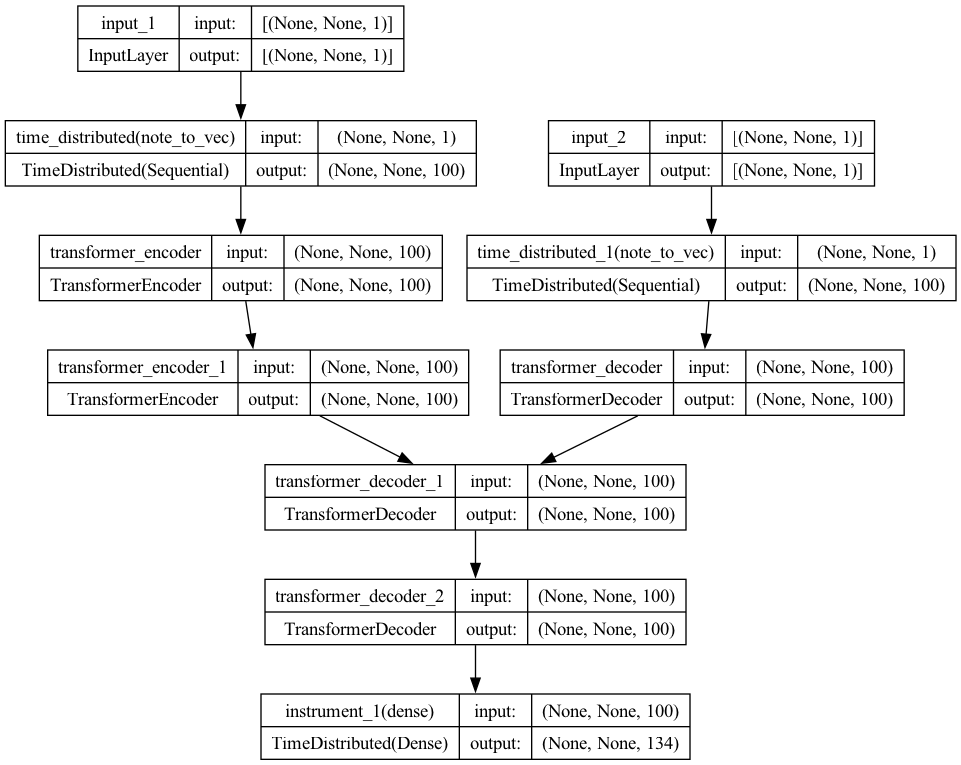

In [3]:
plot_model(model, show_layer_names=True, show_shapes=True)

In [5]:
#output_sequence_len = 0 if not encoder_decoder else >=1

# Data INFO
# ~175K midi files
# Files could be short melodies, loop compositions or long symphonies or songs
# ~10K midi files in each of the 16 top level subdirectories 
# Considering 300 midi files at present, at 8 resolution..~ 0.2% Dataset
# Generating a polyphonic monophony music (multiple instruments each following a monophonic melody line independently) or type of contrapuntal 
train_source, val_source, test_source  = sample_dataset('./lpd_5/all', nsamples=10000, train_size=0.9, val_size=0.2, input_sequence_len=100, output_sequence_len=200, resolution=8, prune_rest_note_percent=0.5, batch_size=128, encoder_decoder=True)

Preparing test dataset...: 100%|██████████| 1000/1000 [00:48<00:00, 20.43it/s]


In [4]:
train_source = ('lpd_5_batched/train_inputs', 'lpd_5_batched/train_outputs')
music_loader = load_music_batches(*train_source, encoder_decoder=True)
steps = len(os.listdir(train_source[0]))-1
steps

10147

In [5]:
val_source = ('lpd_5_batched/val_inputs', 'lpd_5_batched/val_outputs')
val_music_loader = load_music_batches(*val_source, encoder_decoder=True)
val_steps = len(os.listdir(val_source[0]))-1
val_steps

2407

In [6]:
import tensorflow as tf
import os


class ModelCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, model, checkpoint_dir, save_best_only=True):
        super(ModelCheckpoint, self).__init__()
        self.model = model
        self.checkpoint_dir = checkpoint_dir
        self.save_best_only = save_best_only
        self.best_val_loss = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')
        if self.save_best_only and val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            filepath = os.path.join(self.checkpoint_dir, f"best_model.h5")
            self.model.save(filepath)
            print(f"Saved model to {filepath} (val_loss: {val_loss:.4f})")
        else:
            filepath = os.path.join(self.checkpoint_dir, f"model_epoch_{epoch}.h5")
            self.model.save(filepath)
            print(f"Saved model to {filepath} (val_loss: {val_loss:.4f})")

modelname = "encoder-decoder-transformer-10Ksamples-1instrument-longer"
checkpoint_dir = f"./{modelname}-checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
model_checkpoint = ModelCheckpoint(model, checkpoint_dir)
callbacks_list = [model_checkpoint]   


In [7]:
history = model.fit(music_loader, steps_per_epoch=steps, validation_data=val_music_loader, validation_steps=val_steps, epochs=50, callbacks=callbacks_list)

Epoch 1/50
  271/10147 [..............................] - ETA: 2:35:38 - loss: 3.7081 - accuracy: 0.1648

KeyboardInterrupt: 

In [24]:
x, y = next(music_loader)
model(x)

<tf.Tensor: shape=(128, 200, 134), dtype=float32, numpy=
array([[[ 2.6668363 , -4.1391263 , -4.893784  , ...,  1.8053366 ,
          0.02571832, -3.272318  ],
        [ 3.2760868 , -3.836069  , -4.484474  , ...,  2.0610166 ,
          0.40493655, -3.1371398 ],
        [ 2.7078516 , -4.478312  , -5.3704767 , ...,  2.6846058 ,
          1.229209  , -3.5653799 ],
        ...,
        [ 3.8223586 , -4.335686  , -5.423226  , ...,  1.755639  ,
          0.2147048 , -3.4359565 ],
        [ 3.3653007 , -4.550391  , -5.321847  , ...,  2.520461  ,
          1.0533735 , -3.6287034 ],
        [ 0.79586095, -3.586155  , -4.6931763 , ...,  1.1248237 ,
         -0.62415665, -3.2131321 ]],

       [[ 2.9741995 , -4.6180134 , -5.6416216 , ...,  1.5026798 ,
          0.41990918, -3.6128216 ],
        [ 2.9001145 , -4.514207  , -5.738712  , ...,  1.6840254 ,
          0.6353298 , -3.6220894 ],
        [ 2.9688852 , -4.6335716 , -5.6654153 , ...,  1.6482054 ,
          0.41211483, -3.6157084 ],
        ..

In [7]:
model.save(modelname)

INFO:tensorflow:Assets written to: encoder-decoder-transformer-10Ksamples-1instrument-longer/assets


INFO:tensorflow:Assets written to: encoder-decoder-transformer-10Ksamples-1instrument-longer/assets


In [3]:
model = tf.keras.saving.load_model('encoder-decoder-transformer-10Ksamples-1instrument-longer')

In [5]:
tracks = sample_track('lpd_5/all', nsamples=100, input_sequence_len=100, resolution=8)

Sampling tracks...: 100%|██████████| 100/100 [00:01<00:00, 50.32it/s]


In [9]:
x, y = tracks[randint(0, len(tracks)-1)]
composer = compose_music(music_model=model, cue=x, topn=129, encoder_decoder=True, print_gen=True)



In [10]:
x.shape, y.shape

((100, 1), (1861, 1))

In [ ]:
total_track_length = y.shape[0]
composition_length = int(0.5*total_track_length)
TEMPO = 60

print(f"Composing for {composition_length} time steps at {TEMPO} bpm")
for _ in range(composition_length):
    composition = next(composer)
    print(composition[-1])
  


output_midi_path = f'generated_track_transformer.mid'
output_audio_path = f'generated_track_transformer.wav'

print("Composition Done...")
generated_track = make_track(composition, tempo=TEMPO)
print("Track Done...")

multitrack_to_midi(generated_track, output_midi_path)
print("Generated Midi file Done...")

midi_to_wav(output_midi_path, output_audio_path)
print("Generated Audio file Done...")



output_midi_path = 'original_track_transformer.mid'
output_audio_path = 'original_track_transformer.wav'

original_track = make_track(composition=y[:composition_length], tempo=TEMPO, composition_tokenized=False)
print("Original Track Done...")

multitrack_to_midi(original_track, output_midi_path)
print("Original Midi file Done...")
midi_to_wav(output_midi_path, output_audio_path)
print("Original Audio file Done...")